In [85]:
import os
import sys
from pathlib import Path
project_dir = Path().resolve().parent.parent
sys.path.append(str(project_dir))


os.environ['USE_PYGEOS'] = os.environ.get('USE_PYGEOS', '0')

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from IPython.display import Markdown

from masterplan_tools.method import MasterPlan
from masterplan_tools.method.provision import ProvisionModel
from masterplan_tools.models import CityModel
from masterplan_tools.preprocessing import DataGetter



def pandas_to_markdown(df_or_series: pd.DataFrame | pd.Series, value_name: str | None = None) -> Markdown:
    if isinstance(df_or_series, pd.DataFrame):
        return Markdown(
            "\n".join(
                (
                    f"| {' | '.join(column for column in df_or_series.columns)} |",
                    f"| {' | '.join(('---',) * df_or_series.shape[1])} |",
                    "\n".join(
                        f"| {' | '.join(str(value) for value in values)} |" for _, values in df_or_series.iterrows()
                    ),
                )
            )
        )
    elif isinstance(df_or_series, pd.Series):
        if value_name is None:
            value_name = "value"
        return Markdown(
            "\n".join(
                (
                    f"| {df_or_series.name} | {value_name} |",
                    "| --- | --- |",
                    "\n".join(f"| {key} | {round(value)} |" for key, value in df_or_series.items()),
                )
            )
        )
    raise ValueError(f"'{df_or_series}' is neither DataFrame nor Series")

In [86]:
# path to data
example_data_path = "./data"
# TODO: upload example data somewhere and download it in script


# load data required for blocks creation
city_geometry = gpd.read_parquet(os.path.join(example_data_path, "city_geometry.parquet"))
water_geometry = gpd.read_parquet(os.path.join(example_data_path, "water_geometry.parquet"))
roads_geometry = gpd.read_parquet(os.path.join(example_data_path, "roads_geometry.parquet"))
railways_geometry = gpd.read_parquet(os.path.join(example_data_path, "railways_geometry.parquet"))
nature_geometry_boundaries = gpd.read_parquet(os.path.join(example_data_path, "nature_geometry_boundaries.parquet"))

# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet"))

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# load data required for
buildings = gpd.read_parquet(os.path.join(example_data_path, "buildings.parquet"))
greenings = gpd.read_parquet(os.path.join(example_data_path, "greenings.parquet"))
parkings = gpd.read_parquet(os.path.join(example_data_path, "parkings.parquet"))


transport_graph = nx.read_graphml(os.path.join(example_data_path, "new_graph.graphml"))

# data loading with planning area
polygon = gpd.read_file(os.path.join(example_data_path, "polygon.geojson"))

In [87]:
# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [88]:
local_crs = 32636

no_development = gpd.read_file(os.path.join(example_data_path, "no_development_pzz.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)
no_development = no_development[no_development['RAYON']=='Василеостровский']
landuse = gpd.read_file(os.path.join(example_data_path, "landuse_zone_pzz.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)
okn = gpd.read_file(os.path.join(example_data_path, "petropavlovsraya_delete.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)

In [89]:
from masterplan_tools.method import BlocksCutter
from masterplan_tools.method.blocks import BlocksCutterGeometries

geoms = BlocksCutterGeometries(
  city=city_geometry,
  water=water_geometry,
  roads=roads_geometry,
  railways=railways_geometry,
  nature=nature_geometry_boundaries, 
  no_dev=no_development,
  landuse=landuse
)
blocks = BlocksCutter(geometries = geoms).get_blocks() 

In [90]:
from masterplan_tools.method import LuFilter
"""
There are three landuse tags in the blocks gdf:
    1. 'no_dev_area' -- according to th no_debelopment gdf and cutoff without any buildings or specified / selected landuse types;
    2. 'selected_area' -- according to the landuse gdf. We separate theese polygons since they have specified landuse types;
    3. 'buildings' -- there are polygons that have buildings landuse type. 

    In further calculations we will use the in the following steps:
    Only 'buildings' -- to find clusters of buildings in big polygons;
    All of them while calculating the accessibility times among city blocks;
    All of them except 'no_dev_area' while optimizing the development of new facilities.
"""
blocks = LuFilter(blocks.to_gdf(), landuse_geometries = geoms).filter_lu()

/home/vasilstar/masterplanning/masterplan_tools/method/blocks/landuse_filter.py:15: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  landuse = ox.geometries_from_polygon(
/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1803: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


In [91]:
from masterplan_tools.method.blocks.blocks_clustering import BlocksClusterization

buildings_geom = gpd.read_file(os.path.join(example_data_path, "buildings_blocks.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)
blocks = BlocksClusterization(blocks, buildings_geom).run()

100%|██████████| 1/1 [00:00<00:00, 10.92it/s]
1403it [00:01, 1083.12it/s]


In [92]:
blocks.explore(column='landuse', cmap='Accent')

In [99]:
blocks[blocks['landuse'] == 'no_dev_area'].shape[0]

620

In [79]:

# block_t = gpd.read_parquet(os.path.join(example_data_path, "blocks123.parquet"))
block_t = blocks
block_t.reset_index(drop=True, inplace=True)
block_t['id'] = block_t.index
block_t['index'] = block_t['id']
block_t.drop('landuse', axis=1, inplace=True)
block_t.reset_index(drop=True, inplace=True)


In [16]:
# City data model creation
city_model = CityModel(
    services=services,
    city_blocks = block_t,
    city_geometry=city_geometry,
    water_geometry=water_geometry,
    roads_geometry=roads_geometry,
    railways_geometry=railways_geometry,
    nature_geometry_boundaries=nature_geometry_boundaries,
    # accessibility_matrix=accessibility_matrix,
    transport_graph=transport_graph,
    buildings=buildings,
    greenings=greenings,
    parkings=parkings,

)

/home/vasilstar/masterplanning/masterplan_tools/preprocessing/accs_matrix_calculator.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.blocks.rename(columns={"index": "id"}, inplace=True)


Restoring living area:   0%|          | 0/3748 [00:00<?, ?it/s]

Restoring living area squash:   0%|          | 0/3748 [00:00<?, ?it/s]

In [17]:
services_prov = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    print(service_type)
    services_prov[service_type] = provision.run()

schools
kindergartens
recreational_areas
hospitals
pharmacies
policlinics


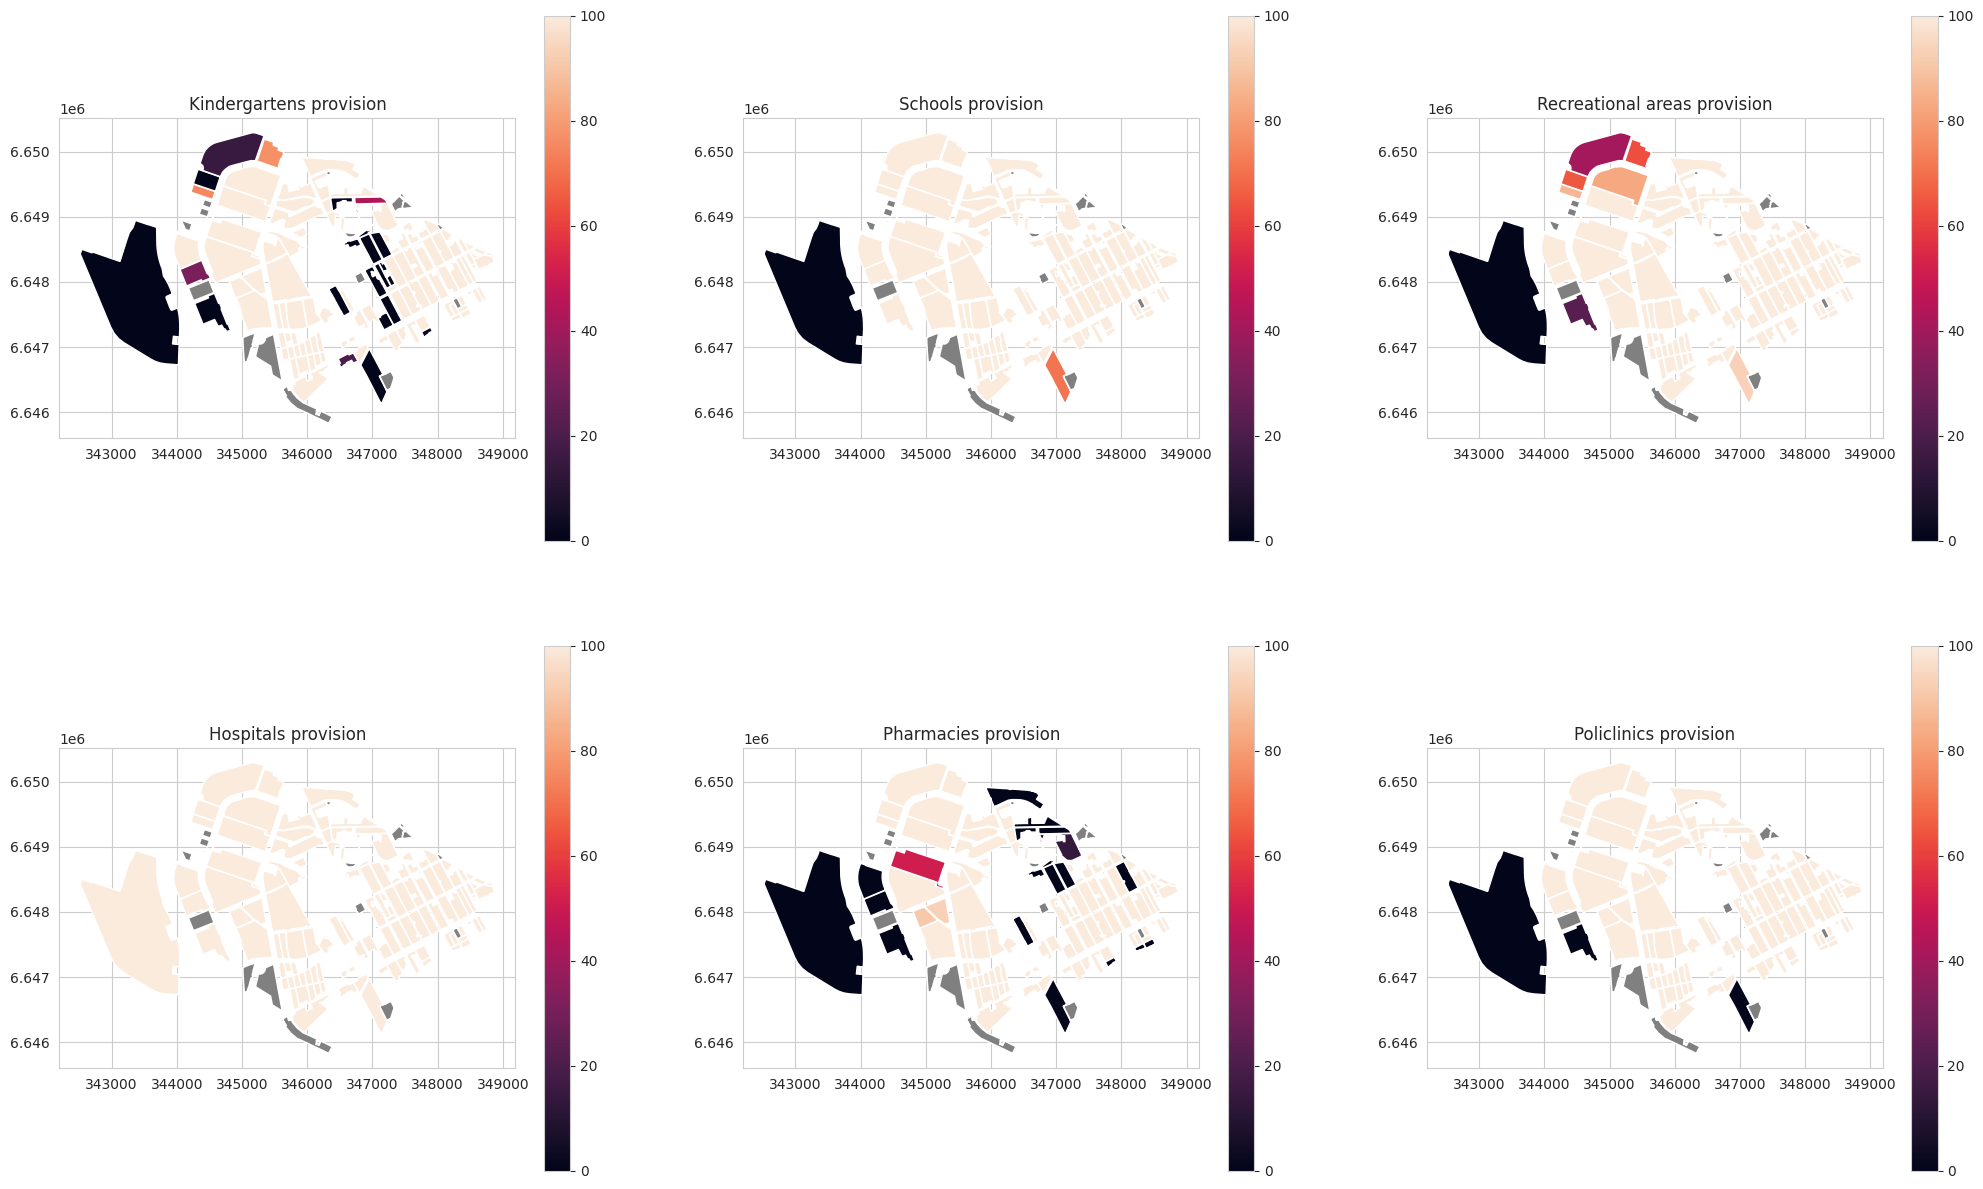

In [18]:
from matplotlib.gridspec import GridSpec

kindergartens_prov = services_prov["kindergartens"]
schools_prov = services_prov["schools"]
recreational_areas_prov = services_prov["recreational_areas"]
hospitals_prov = services_prov["hospitals"]
pharmacies_prov = services_prov["pharmacies"]
policlinics_prov = services_prov["policlinics"]

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
kindergartens_prov.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
kindergartens_prov[kindergartens_prov["population"] == 0].plot(ax=ax1, color="grey", alpha=1)

ax2 = fig.add_subplot(gs[0, 1])
schools_prov.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
schools_prov[schools_prov["population"] == 0].plot(ax=ax2, color="grey", alpha=1)

ax3 = fig.add_subplot(gs[0, 2])
recreational_areas_prov.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")
recreational_areas_prov[recreational_areas_prov["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

ax4 = fig.add_subplot(gs[1, 0])
hospitals_prov.plot(column="provision_hospitals", legend=True, ax=ax4)
ax4.set_title("Hospitals provision")
hospitals_prov[hospitals_prov["population"] == 0].plot(ax=ax4, color="grey", alpha=1)

ax5 = fig.add_subplot(gs[1, 1])
pharmacies_prov.plot(column="provision_pharmacies", legend=True, ax=ax5)
ax5.set_title("Pharmacies provision")
pharmacies_prov[pharmacies_prov["population"] == 0].plot(ax=ax5, color="grey", alpha=1)

ax6 = fig.add_subplot(gs[1, 2])
policlinics_prov.plot(column="provision_policlinics", legend=True, ax=ax6)
ax6.set_title("Policlinics provision")
policlinics_prov[policlinics_prov["population"] == 0].plot(ax=ax6, color="grey", alpha=1)

plt.show()

In [19]:
prov = pd.concat([df if i==0 else df.drop(['id', 'geometry', 'population'], axis=1) for i, df in enumerate(services_prov.values())], axis=1)

In [20]:
prov.drop('level_0', axis=1, inplace=True)
prov

geometry   id  \
0    POLYGON ((344927.436 6647260.005, 344932.793 6...    0   
1    POLYGON ((344668.246 6647329.996, 344664.931 6...    1   
2    POLYGON ((343410.775 6648927.326, 343411.091 6...    2   
3    POLYGON ((344387.905 6647765.234, 344348.350 6...    3   
4    POLYGON ((344278.209 6648289.025, 344286.201 6...    4   
..                                                 ...  ...   
135  POLYGON ((348845.322 6648432.009, 348845.375 6...  135   
136  POLYGON ((348745.252 6648445.145, 348745.186 6...  136   
137  POLYGON ((348575.964 6648538.354, 348567.546 6...  137   
138  POLYGON ((344198.002 6648784.660, 344133.949 6...  138   
139  POLYGON ((344421.844 6648904.751, 344398.071 6...  139   

     provision_schools  population_prov_schools  population_unprov_schools  \
0                    0                        0                          0   
1                  100                      334                          0   
2                    0                        0                      17747   
3                    0                        0                          0   
4                  100                      473                          0   
..                 ...                      ...                        ...   
135                100                       25                          0   
136                100                       67                          0   
137                100                       49                          0   
138                  0                        0                          0   
139                  0                        0                          0   

     population  provision_kindergartens  population_prov_kindergartens  \
0             0                        0                              0   
1          2784                        0                              0   
2         17747                        0                              0   
3             0                        0                              0   
4          3946                       31                             75   
..          ...                      ...                            ...   
135         209                      100                             12   
136         560                      100                             34   
137         411                      100                             25   
138           0                        0                              0   
139           0                        0                              0   

     population_unprov_kindergartens  provision_recreational_areas  ...  \
0                                  0                             0  ...   
1                                169                            23  ...   
2                              17747                             0  ...   
3                                  0                             0  ...   
4                                165                           100  ...   
..                               ...                           ...  ...   
135                                0                           100  ...   
136                                0                           100  ...   
137                                0                           100  ...   
138                                0                             0  ...   
139                                0                             0  ...   

     population_unprov_recreational_areas  provision_hospitals  \
0                                       0                    0   
1                                    2138                  100   
2                                   17747                  100   
3                                       0                    0   
4                                       0                  100   
..                                    ...                  ...   
135                                     0                  100   
136                   

In [21]:
df = city_model.blocks_aggregated_info.merge(prov)
del prov
df

level_0                                           geometry  block_id  \
0          0  POLYGON ((344927.436 6647260.005, 344932.793 6...         0   
1          1  POLYGON ((344668.246 6647329.996, 344664.931 6...         1   
2          2  POLYGON ((343410.775 6648927.326, 343411.091 6...         2   
3          3  POLYGON ((344387.905 6647765.234, 344348.350 6...         3   
4          4  POLYGON ((344278.209 6648289.025, 344286.201 6...         4   
..       ...                                                ...       ...   
135      135  POLYGON ((348845.322 6648432.009, 348845.375 6...       135   
136      136  POLYGON ((348745.252 6648445.145, 348745.186 6...       136   
137      137  POLYGON ((348575.964 6648538.354, 348567.546 6...       137   
138      138  POLYGON ((344198.002 6648784.660, 344133.949 6...       138   
139      139  POLYGON ((344421.844 6648904.751, 344398.071 6...       139   

     current_population  floors  current_living_area  current_green_capacity  \
0                   0.0     0.0               0.0000                     0.0   
1                2784.0     0.0           15945.6100                   886.0   
2               17747.0    16.5           64035.0910                     0.0   
3                   0.0     2.5               0.0000                  2975.0   
4                3946.0     3.5           19338.3360                  4095.0   
..                  ...     ...                  ...                     ...   
135               209.0     5.0            3252.7300                     0.0   
136               560.0     3.0            7489.1551                  7059.0   
137               411.0     4.0            5647.5920                     0.0   
138                 0.0     3.0               0.0000                     0.0   
139                 0.0     1.0               0.0000                     0.0   

     current_green_area  current_parking_capacity  current_industrial_area  \
0                   0.0                       0.0                  42.6397   
1                6347.0                      14.0               27746.6269   
2                   0.0                    2244.0               10828.9367   
3                2900.0                    2636.0               16523.0927   
4                1900.0                      44.0                7108.8195   
..                  ...                       ...                      ...   
135                 0.0                       0.0                   0.0000   
136              1125.0                       0.0                2856.6114   
137                 0.0                       0.0                   0.0000   
138                 0.0                       0.0                1535.7700   
139                 0.0                       0.0                 559.9940   

     ...  population_unprov_recreational_areas  provision_hospitals  \
0    ...                                     0                    0   
1    ...                                  2138                  100   
2    ...                                 17747                  100   
3    ...                                     0                    0   
4    ...                                     0                  100   
..   ...                                   ...                  ...   
135  ...                                     0                  100   
136  ...                                     0                  100   
137  ...                                     0                  100   
138  ...                                     0                    0   
139  ...                                     0                    0   

     population_prov_hospitals  population_unprov_hospitals  \
0                            0                            0   
1                           25                            0   
2                          159                            0   
3                            0                            0   
4             

In [22]:
df = df[['block_id', 'geometry' , 'current_population', 'population', 'area',
    'floors', 'current_living_area', 'current_industrial_area',
    'current_green_area',
    'current_green_capacity', 'current_parking_capacity',
    'population_prov_schools', 'population_unprov_schools',
    'population_prov_kindergartens', 'population_unprov_kindergartens',
    'population_prov_recreational_areas', 'population_unprov_recreational_areas',
    'population_prov_hospitals', 'population_unprov_hospitals',
    'population_prov_policlinics', 'population_unprov_policlinics',
    'population_prov_pharmacies', 'population_unprov_pharmacies']]

In [23]:
# df.isna().sum()[df.isna().sum()!=0]
# df[df['floors'].isna()][['population', 'current_living_area']].describe()
df['floors'].fillna(0, inplace=True)
# (df['current_population'] != df['population']).sum()
df.drop(['current_population'], axis=1, inplace=True)

/tmp/ipykernel_6134/1962215181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['floors'].fillna(0, inplace=True)
/tmp/ipykernel_6134/1962215181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['current_population'], axis=1, inplace=True)


In [24]:
HECTARE_IN_SQUARE_METERS = 10_000

df[['area', 'current_living_area', 'current_industrial_area', 'current_green_area']] = df[['area', 'current_living_area', 'current_industrial_area', 'current_green_area']]/HECTARE_IN_SQUARE_METERS

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
df['free_area'] = df['area']*0.8 - df['current_green_area'] - df['current_industrial_area'] - df['current_living_area']

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [26]:
services_dict = {
    'schools': {250: 1.2, 300: 1.1, 600: 1.3, 800: 1.5, 1100: 1.8},
    'kindergartens': {180: 0.72, 250: 1.44, 280: 1.1},
    'recreational_areas': {1000: 0.12},
    'pharmacies': {1000: 0.005},
    'hospitals': {500: 4, 1000: 8, 5000: 40, 10000: 80},
    'policlinics': {1000: 1.1, 3000: 3, 5000: 5}
}

In [27]:
d = {}
for k,v in services_dict.items():
    for kk,vv in v.items():
        d[k+'_'+str(kk)]=vv
d_ = pd.DataFrame([d]).T

In [28]:
d_

0
schools_250               1.200
schools_300               1.100
schools_600               1.300
schools_800               1.500
schools_1100              1.800
kindergartens_180         0.720
kindergartens_250         1.440
kindergartens_280         1.100
recreational_areas_1000   0.120
pharmacies_1000           0.005
hospitals_500             4.000
hospitals_1000            8.000
hospitals_5000           40.000
hospitals_10000          80.000
policlinics_1000          1.100
policlinics_3000          3.000
policlinics_5000          5.000

In [29]:
import itertools

In [30]:
comb = [list(itertools.combinations(list(d.keys()), i)) for i in range(1, 4)]
comb = [item for sublist in comb for item in sublist]

In [31]:
comb_w = []
for comb_ in comb:
    comb_w.append(d_.loc[list(comb_)].sum()[0])

In [32]:
df['variants'] = df['free_area'].apply(lambda x: [i for i,com in enumerate(comb_w) if com<=x])

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [33]:
df['variants']

0                                                    [9]
1      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16,...
2      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
3      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 17, 18,...
4      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16,...
                             ...                        
135                                                  [9]
136                                          [8, 9, 117]
137                                                  [9]
138                          [5, 8, 9, 89, 90, 117, 632]
139                                                  [9]
Name: variants, Length: 140, dtype: object

In [34]:
total_vars = list(set([item for sublist in df['variants'].tolist() for item in sublist]))

In [35]:
variants = pd.DataFrame(columns=services.keys(), index=range(833)).fillna(0)
for i,_ in enumerate(comb):
    for el in [x.rsplit('_', maxsplit=1) for x in _]:
        variants.loc[i, el[0]] += int(el[1])

In [36]:
variants

schools  kindergartens  recreational_areas  hospitals  pharmacies  \
0        250              0                   0          0           0   
1        300              0                   0          0           0   
2        600              0                   0          0           0   
3        800              0                   0          0           0   
4       1100              0                   0          0           0   
..       ...            ...                 ...        ...         ...   
828        0              0                   0       5000           0   
829        0              0                   0      10000           0   
830        0              0                   0      10000           0   
831        0              0                   0      10000           0   
832        0              0                   0          0           0   

     policlinics  
0              0  
1              0  
2              0  
3              0  
4              0  
..           ...  
828         8000  
829         4000  
830         6000  
831         8000  
832         9000  

[833 rows x 6 columns]

In [37]:
import numpy as np

In [38]:
blocks = np.zeros(140)

In [39]:
blocks_for_change = np.random.randint(0, 140, 10)
change_variants = np.random.randint(0, 832, 10)

In [40]:
blocks[blocks_for_change] = change_variants

In [41]:
def fitness_func(ga_instance, blocks, solution_idx):
    updated_block_dict = {}

    for i, block_id in enumerate(blocks.nonzero()[0]):
        updated_block = {
            'block_id': df.loc[block_id]['block_id'],
            'population': df.loc[block_id]['population']}
        for k,v in variants.loc[blocks[block_id]].to_dict().items():
            updated_block[k+'_capacity'] = v

        updated_block_dict[i] = updated_block

    services_graph_new = nx.Graph()
    for service_type in services.keys():
        services_graph_new = DataGetter().prepare_graph(
            blocks=city_model.city_blocks,
            service_type=service_type,
            buildings=city_model.buildings,
            service_gdf=city_model.services_gdfs[service_type],
            updated_block_info=updated_block_dict,
            accessibility_matrix=city_model.accessibility_matrix,
            services_graph=services_graph_new,
        )

    city_model.services_graph = services_graph_new

    services_prov = {}
    for service_type in services.keys():
        provision = ProvisionModel(city_model=city_model, service_name=service_type)
        temp = provision.run()
        temp = temp[temp['population']!=0]
        services_prov[service_type] = 1/6*(temp['population_prov_' + service_type]/
                                           (temp['population_prov_' + service_type] +
                                            temp['population_unprov_' + service_type])).mean()

    fitness = sum(services_prov.values())

    return fitness

In [42]:
fitness_func(None, blocks, None)

0.9485738032137722

In [43]:
df['len_variants'] = df['variants'].apply(lambda x: len(x))

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [44]:
import pygad

In [45]:
ga_instance = pygad.GA(num_generations=3,
                       num_parents_mating=6,

                       fitness_func=fitness_func,

                       sol_per_pop=6,
                       num_genes=df[df['len_variants']!=0].reset_index(drop=True).shape[0],
                       gene_space=df[df['len_variants']!=0].reset_index(drop=True)['variants'].tolist(),
                       gene_type=int,

                       mutation_type='adaptive',
                       mutation_percent_genes=(90, 10),

                       # on_crossover = on_crossover,
                       crossover_type='scattered',

                       parent_selection_type='tournament',
                       K_tournament=3,

                       stop_criteria='saturate_50',
                       parallel_processing=12)

In [46]:
# ga_instance.plot_fitness()

In [47]:
solution = ga_instance.best_solution()[0]

In [48]:
updated_block_dict = {}

for i, block_id in enumerate(solution.nonzero()[0]):
    updated_block = {
        'block_id': df.loc[block_id]['block_id'],
        'population': df.loc[block_id]['population']}
    for k,v in variants.loc[solution[block_id]].to_dict().items():
        updated_block[k+'_capacity'] = v

    updated_block_dict[i] = updated_block

In [49]:
# city_model.services_graph = services_graph
# services_prov = {}
# for service_type in services.keys():
#     provision = ProvisionModel(city_model=city_model, service_name=service_type)
#     services_prov[service_type] = provision.run()

In [50]:
comb[9]

('pharmacies_1000',)

In [51]:
solution

array([  9, 291, 588,   4, 243, 500,  25, 226,  54,  17, 219,   9, 422,
         5, 549,  90, 117,   8, 122, 326, 192, 433, 718, 577,  64,   9,
       383, 169,  75,   1,  66, 632, 108,   8,   9,   8,   8, 117,  89,
         9, 117,   8,   8, 614, 623, 109, 117,  97, 713,  84, 304, 313,
         9, 347, 753,   8, 117,   8,  67,   6, 278,   8,  90,  24,  78,
        89,  36,   9,   9,  40, 274,   9,   3, 342,  23, 152, 279,  39,
       117,   8,   9, 100, 624,   0,   9,   7,  90, 215, 159, 725, 117,
       129, 117,  90,   8,   8,   9,   5,  90, 117,   8, 117,   8, 117,
         8,   2, 632,  14,  99, 237, 117, 753,  95, 615,   8,  79,   9,
         9,   8,   9,   8,   8,   8,   9,   8, 117,   8,   8, 210,   8,
         9,   8,   9,   8,   9])

In [52]:
services_graph_new = nx.Graph()
for service_type in services.keys():
    services_graph_new = DataGetter().prepare_graph(
        blocks=city_model.city_blocks,
        service_type=service_type,
        buildings=city_model.buildings,
        service_gdf=city_model.services_gdfs[service_type],
        updated_block_info=updated_block_dict,
        accessibility_matrix=city_model.accessibility_matrix,
        services_graph=services_graph_new,
    )

city_model.services_graph = services_graph_new

services_prov_new = {}
for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov_new[service_type] = provision.run()

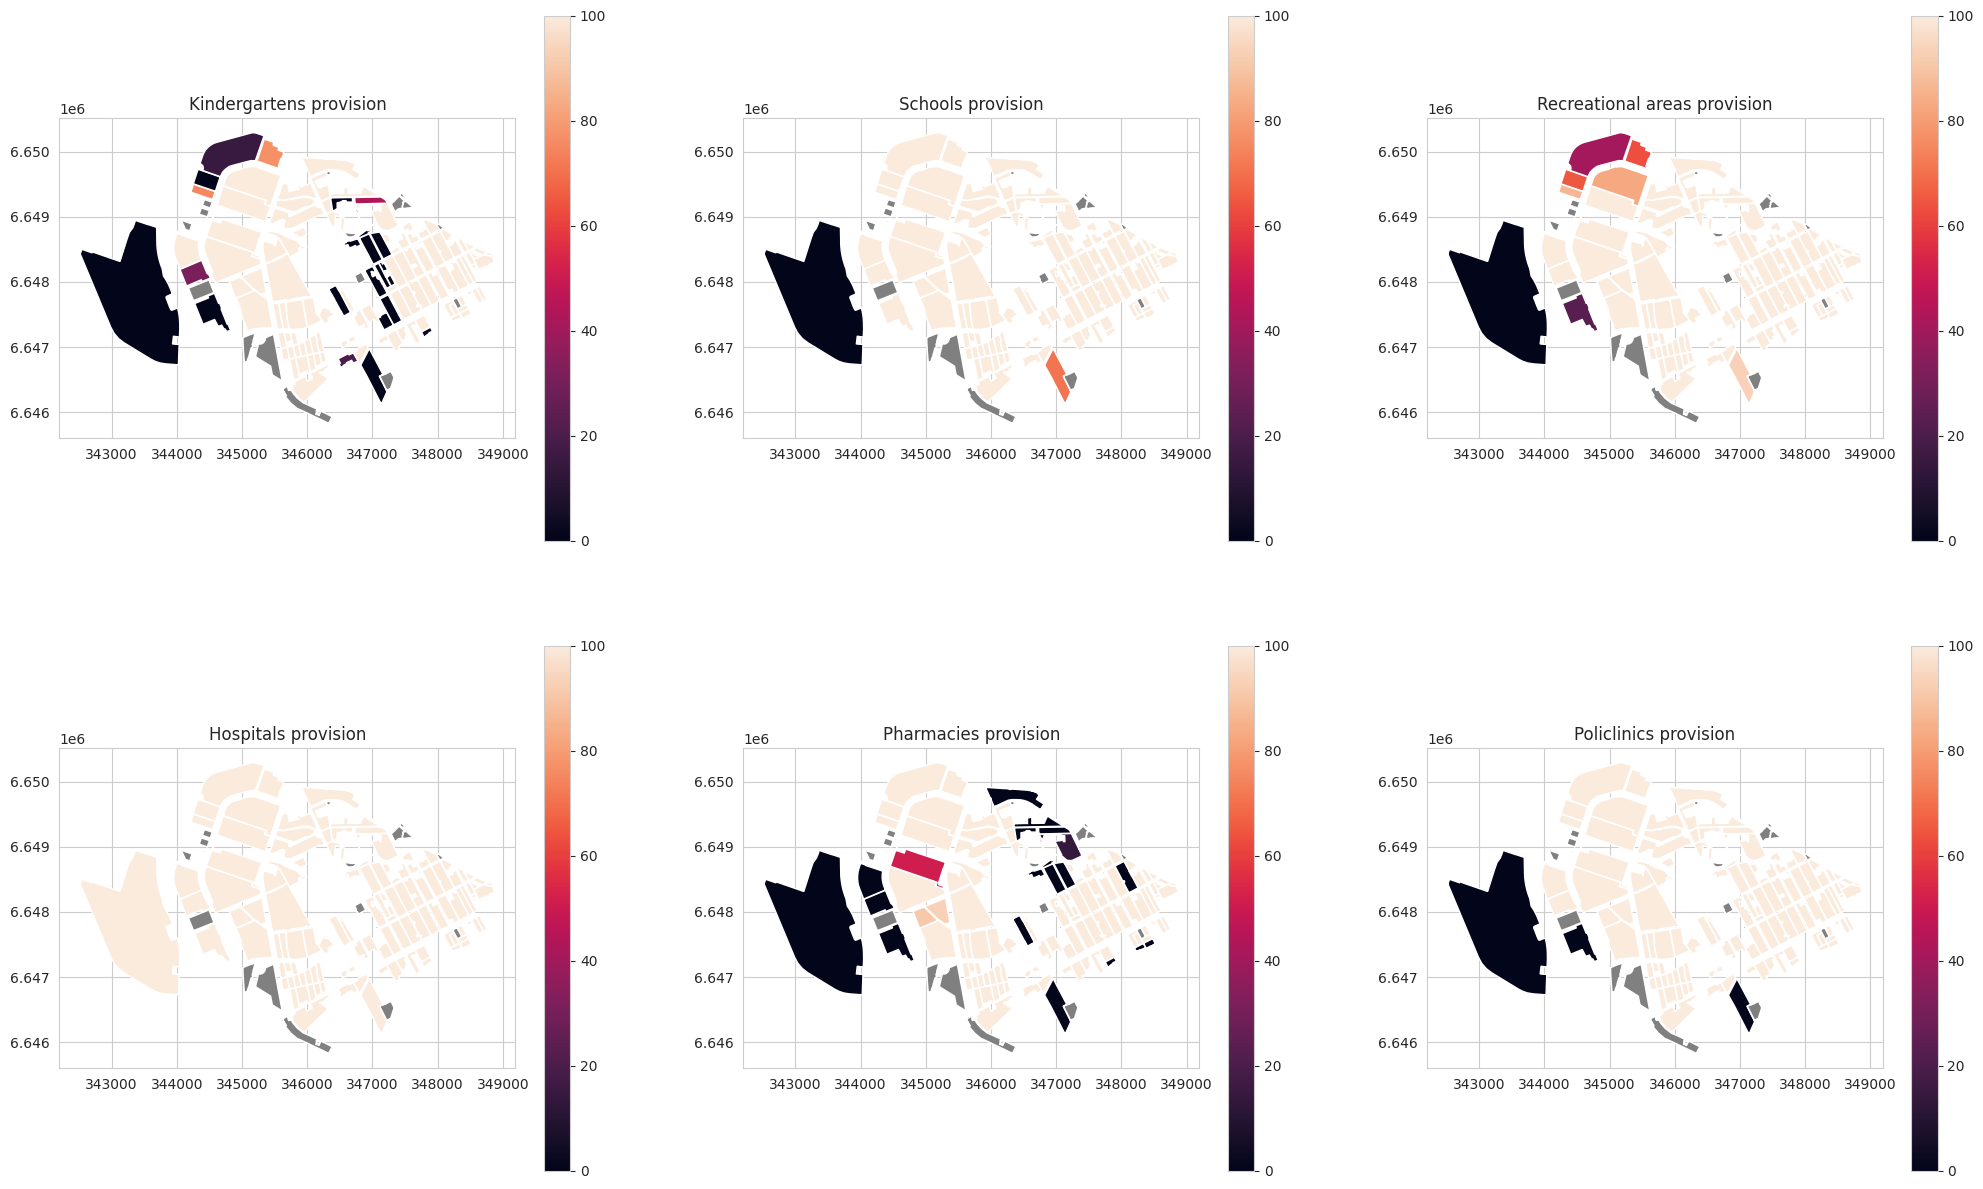

In [53]:
from matplotlib.gridspec import GridSpec

kindergartens_prov = services_prov["kindergartens"]
schools_prov = services_prov["schools"]
recreational_areas_prov = services_prov["recreational_areas"]
hospitals_prov = services_prov["hospitals"]
pharmacies_prov = services_prov["pharmacies"]
policlinics_prov = services_prov["policlinics"]

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
kindergartens_prov.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
kindergartens_prov[kindergartens_prov["population"] == 0].plot(ax=ax1, color="grey", alpha=1)

ax2 = fig.add_subplot(gs[0, 1])
schools_prov.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
schools_prov[schools_prov["population"] == 0].plot(ax=ax2, color="grey", alpha=1)

ax3 = fig.add_subplot(gs[0, 2])
recreational_areas_prov.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")
recreational_areas_prov[recreational_areas_prov["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

ax4 = fig.add_subplot(gs[1, 0])
hospitals_prov.plot(column="provision_hospitals", legend=True, ax=ax4)
ax4.set_title("Hospitals provision")
hospitals_prov[hospitals_prov["population"] == 0].plot(ax=ax4, color="grey", alpha=1)

ax5 = fig.add_subplot(gs[1, 1])
pharmacies_prov.plot(column="provision_pharmacies", legend=True, ax=ax5)
ax5.set_title("Pharmacies provision")
pharmacies_prov[pharmacies_prov["population"] == 0].plot(ax=ax5, color="grey", alpha=1)

ax6 = fig.add_subplot(gs[1, 2])
policlinics_prov.plot(column="provision_policlinics", legend=True, ax=ax6)
ax6.set_title("Policlinics provision")
policlinics_prov[policlinics_prov["population"] == 0].plot(ax=ax6, color="grey", alpha=1)

plt.show()
